# Mental Health Analysis

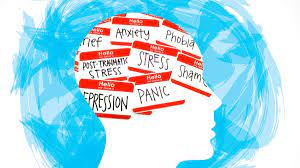

## Overview

For this project I analyzed over 6,000 college student mental health surveys. As mental health strongly affects people's lives, it's imperative that developmental institutions, like colleges, do all they can to support students. The survey consisted of questions regarding various aspects of students' lives including sleep, diet, and more. My goal was to build a predictive model that would be able to identify students that were high and low risk for depression based on their answers to the survey questions. Before modeling I performed a preprocessing approach that included:

- making risk for Depression a binary
- scaling numerical columns
- one-hot encoding categorical columns
- ordinal encoding hierarchical categorical columns

Then I began to build models that aimed to increase the recall and accuracy scores. My final model had a 49% recall score and a 51% accuracy score.

This is more accurate than my dummy model, but the recall score is much lower. While I did have a Logistic Regression model that had an 80% cross validation recall score on training data, the cross validation accuracy score was 46%. My goal was to have above 50% for both scores. While I just barely missed that goal, I did learn a lot in the process. I reached the conclusion that humans may be unreliable in self-assessments and that humans are multi-faceted. In order to make a better model, we need more reliable data. This can be achieved through quantifiable questions given to cohort surveys that follow students over time. 

## Business Problem

Mental health affects all of us. The better we are at detecting warning signs, the better we will be at supporting each other. Developmental institutions, like colleges, have a particulary large responsibility to help students in this area as much as possible. In a 2022 article from the [American Psychological Association](https://www.apa.org/monitor/2022/10/mental-health-campus-care), "more than 60% of college students met the criteria for at least one mental health problem." Luckily, this conversation is starting to gain momentum. The article goes on to detail how psychologists are becoming more involved with colleges and how supports are being put in place to help students, including a wellness app. This project seeks to work in tandem with this push and help shed light on which aspects of students' lives correlate with a high risk for depression. With that information, colleges and psychologists can put more tailored supports in place for students.

## Data Understanding

The data comes from [kaggle.com](https://www.kaggle.com/datasets/sonia22222/students-mental-health-assessments?select=students_mental_health_survey.csv). It consists of over 6,000 mental health surveys where college students provided information regarding their courses, sleep quality, physical activity, social support, and many more aspects of their lives. In this project I will be converting the Depression_Score to a binary target. Three or higher is Yes, this student has depression, and two or below means no, this student does not have depression. My goal is to find which aspects of a student's life has the greatest impact on their probability of having depression. 

Instructions on accessing data:
Option 1 (kaggle.com):
1. Go to [kaggle.com](https://www.kaggle.com/datasets/sonia22222/students-mental-health-assessments?select=students_mental_health_survey.csv)
2. Scroll down to the students_mental_health_survey.csv and select download.

Option 2 (GitHub repo):
1. Go to the [GitHub repo](https://github.com/rbdaly16/Student-Mental-Health-Analysis/tree/main)
2. Fork and clone or just pull the repo down and you will have access to the data csv located in the data folder.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize, OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [2]:
# Read the data in to a dataframe
df = pd.read_csv('data/students_mental_health_survey.csv')

In [3]:
df.head()

,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,19,Computer Science,Male,3.65,2,1,0,Average,Low,Average,Moderate,Single,NaN,Never,No,No,4,Moderate,20,Off-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          7022 non-null   int64  
 1   Course                       7022 non-null   object 
 2   Gender                       7022 non-null   object 
 3   CGPA                         7010 non-null   float64
 4   Stress_Level                 7022 non-null   int64  
 5   Depression_Score             7022 non-null   int64  
 6   Anxiety_Score                7022 non-null   int64  
 7   Sleep_Quality                7022 non-null   object 
 8   Physical_Activity            7022 non-null   object 
 9   Diet_Quality                 7022 non-null   object 
 10  Social_Support               7022 non-null   object 
 11  Relationship_Status          7022 non-null   object 
 12  Substance_Use                7007 non-null   object 
 13  Counseling_Service

In [5]:
df.describe()

,Age,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Financial_Stress,Semester_Credit_Load
count,7022.000000,7010.00000,7022.000000,7022.000000,7022.000000,7022.000000,7022.000000
mean,23.003418,3.49127,2.427941,2.254486,2.300484,2.453005,22.010538
std,3.853978,0.28742,1.638408,1.625193,1.624305,1.708995,4.358380
min,18.000000,2.44000,0.000000,0.000000,0.000000,0.000000,15.000000
25%,20.000000,3.29000,1.000000,1.000000,1.000000,1.000000,18.000000
50%,22.000000,3.50000,2.000000,2.000000,2.000000,2.000000,22.000000
75%,25.000000,3.70000,4.000000,3.000000,4.000000,4.000000,26.000000
max,35.000000,4.00000,5.000000,5.000000,5.000000,5.000000,29.000000


In [6]:
df['CGPA'].value_counts()

4.00    332
3.51    106
3.58    106
3.55    105
3.50    103
       ... 
2.67      1
2.44      1
2.63      1
2.58      1
2.49      1
Name: CGPA, Length: 143, dtype: int64

In [7]:
df['Sleep_Quality'].value_counts()

Good       3589
Average    2735
Poor        698
Name: Sleep_Quality, dtype: int64

In [8]:
df['Physical_Activity'].value_counts()

Moderate    3521
Low         2091
High        1410
Name: Physical_Activity, dtype: int64

In [9]:
df['Diet_Quality'].value_counts()

Average    4268
Good       1385
Poor       1369
Name: Diet_Quality, dtype: int64

In [10]:
df['Social_Support'].value_counts()

Moderate    3470
High        2176
Low         1376
Name: Social_Support, dtype: int64

In [11]:
df['Relationship_Status'].value_counts()

Single               3574
In a Relationship    2079
Married              1369
Name: Relationship_Status, dtype: int64

In [12]:
df['Substance_Use'].value_counts()

Never           5903
Occasionally     699
Frequently       405
Name: Substance_Use, dtype: int64

In [13]:
df['Counseling_Service_Use'].value_counts()

Never           4263
Occasionally    2081
Frequently       678
Name: Counseling_Service_Use, dtype: int64

In [14]:
df['Family_History'].value_counts()

No     4866
Yes    2156
Name: Family_History, dtype: int64

In [15]:
df['Chronic_Illness'].value_counts()

No     6678
Yes     344
Name: Chronic_Illness, dtype: int64

In [16]:
df['Financial_Stress'].value_counts()

0    1230
1    1184
2    1176
4    1161
3    1155
5    1116
Name: Financial_Stress, dtype: int64

In [17]:
df['Extracurricular_Involvement'].value_counts()

Moderate    3440
Low         2164
High        1418
Name: Extracurricular_Involvement, dtype: int64

In [18]:
df['Semester_Credit_Load'].value_counts()

27    513
17    509
28    491
15    472
18    468
19    467
24    466
16    466
22    461
29    461
25    460
26    456
23    446
21    444
20    442
Name: Semester_Credit_Load, dtype: int64

In [19]:
df['Age'].value_counts()

21    777
18    738
20    723
19    710
22    694
23    642
24    539
26    457
25    455
27    323
28    260
29    189
30    162
31    124
32     98
33     55
34     45
35     31
Name: Age, dtype: int64

In [20]:
df['Extracurricular_Involvement'].value_counts()

Moderate    3440
Low         2164
High        1418
Name: Extracurricular_Involvement, dtype: int64

In [21]:
df['Depression_Score'].value_counts()

3    1388
1    1308
2    1304
0    1295
4     884
5     843
Name: Depression_Score, dtype: int64

## Data Preparation

In order to prepare the data for preprocessing, I first dropped the 27 rows containing null values. Once I was working with a clean dataset, I then created a binary column for Depression. In the survey, students selected a number between 0 and 5 for their Depression. I created a column titled 'Depression Binary' that had 'Yes' if the depression score was 3 or higher, and 'No' if the depression score below 3. I did this in order to create a binary classification model. This type of model simplifies the process for the schools as they can use this to determine whether a student is more or less likely to need additional support. 

After this, the preprocessing steps performed included:

* scaling numerical columns
* one-hot encoding categorical columns
* ordinal encoding hierarchical categorical columns 

In [22]:
df.isna().sum()

Age                             0
Course                          0
Gender                          0
CGPA                           12
Stress_Level                    0
Depression_Score                0
Anxiety_Score                   0
Sleep_Quality                   0
Physical_Activity               0
Diet_Quality                    0
Social_Support                  0
Relationship_Status             0
Substance_Use                  15
Counseling_Service_Use          0
Family_History                  0
Chronic_Illness                 0
Financial_Stress                0
Extracurricular_Involvement     0
Semester_Credit_Load            0
Residence_Type                  0
dtype: int64

Dropped the 27 rows (.38% of the dataset) with null values.

In [23]:
# Drop Nulls
df.dropna(inplace=True)

In [24]:
# Confirm dropping Nulls worked
df.isna().sum()

Age                            0
Course                         0
Gender                         0
CGPA                           0
Stress_Level                   0
Depression_Score               0
Anxiety_Score                  0
Sleep_Quality                  0
Physical_Activity              0
Diet_Quality                   0
Social_Support                 0
Relationship_Status            0
Substance_Use                  0
Counseling_Service_Use         0
Family_History                 0
Chronic_Illness                0
Financial_Stress               0
Extracurricular_Involvement    0
Semester_Credit_Load           0
Residence_Type                 0
dtype: int64

In [25]:
df

,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus
5,21,Medical,Female,3.35,2,4,3,Good,Moderate,Good,High,Single,Never,Never,No,No,5,Moderate,19,Off-Campus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,20,Law,Female,3.33,1,1,1,Average,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,3,Moderate,29,Off-Campus
7017,20,Law,Female,3.69,3,1,5,Good,Low,Poor,High,Single,Never,Frequently,Yes,No,1,High,26,Off-Campus
7018,24,Medical,Female,3.73,3,4,1,Good,Moderate,Average,High,Single,Never,Occasionally,No,No,3,Low,15,Off-Campus
7019,26,Others,Male,3.65,4,5,1,Good,High,Poor,Moderate,Married,Never,Occasionally,No,Yes,4,Moderate,17,Off-Campus


In order to create a binary classification model, I converted the Depression Score into a Depression Binary of 1 for High Risk or 0 for Low Risk. This way the school will be able to see at a high level which students are more likely to need additional support. I chose three as the cut off point because people tend to be embarrassed to say they are depressed even in an anonymous survey. So answering a three may actually be closer to a four or five. On the other hand, one could argue that people put three as a middle ground because they are thinking 'meh, everyone's a little bit sad.' This leads to the point that we need more quantifiable data and less subjective responses.

In [26]:
# Create Binary Depression column for target variable
df.loc[df['Depression_Score'] >= 3, 'Depression_Binary'] = 1
df.loc[df['Depression_Score'] < 3, 'Depression_Binary'] = 0
df.drop('Depression_Score', axis=1, inplace=True)

Before I started modeling, I wanted to see if there were any obvious correlations between certain column values (such as poor, average, and good quality of sleep) and students being high risk for depression. To do this I created bar charts to show the high risk students for each column and the percentage breakdown of each value.

In [27]:
# Create bar chart of high risk students - percentage breakdown by column
def plot_hr_column_perc(column):

    # Obtain percentage values for each ket in the category
    column_perc = df[column].loc[df['Depression_Binary']==1].value_counts(normalize=True)
    
    # Create empty lists for x and y to hold the keys and values
    x = []
    y = []

    # Assign keys and values to x and y respectively
    for key, value in column_perc.items():
        if type(key) == 'string':
            visual_key = key.replace('_', ' ')
            x.append(visual_key)
            y.append(value)
        else:
            x.append(key)
            y.append(value)
    
   # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x, y)

    # Set the title and axis labels
    plt.title(f"Percentage of High Risk Students for {column.replace('_', ' ')}", fontsize=14)
    plt.xlabel(column.replace('_',' '), fontsize=12)
    plt.ylabel(f"Percentage", fontsize=12)

    # Show the plot
    plt.show()
    print('Percentage Breakdown of Categories')
    print(df[column].value_counts(normalize=True))
    print()

The graphs below were quite surprising to me as there did not appear to be many factors highly correlated with a high risk of depression. When there does appear to be a correlation, it does not seem very meaningful because it is typically just because that is the majority of the data. For example, according the the Sleep Quality graph, the majority of high risk students have a Good sleep quality. This makes sense because in the dataset, students who responded Good account for about 51% of the population. 

One strange graph that brings a big question to light is the Substance Use. 80% of students reported that they never used any substances. 80%! This is highly skeptical.

Age


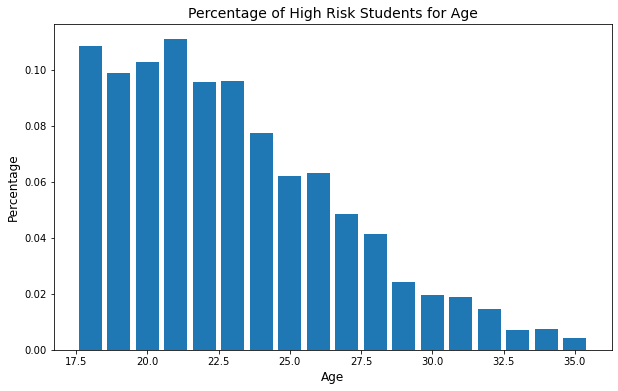

Percentage Breakdown of Categories
21    0.110936
18    0.105075
20    0.103074
19    0.101215
22    0.098642
23    0.091065
24    0.076769
26    0.064904
25    0.064904
27    0.046176
28    0.036741
29    0.026876
30    0.023159
31    0.017727
32    0.014010
33    0.007863
34    0.006433
35    0.004432
Name: Age, dtype: float64

None
Course


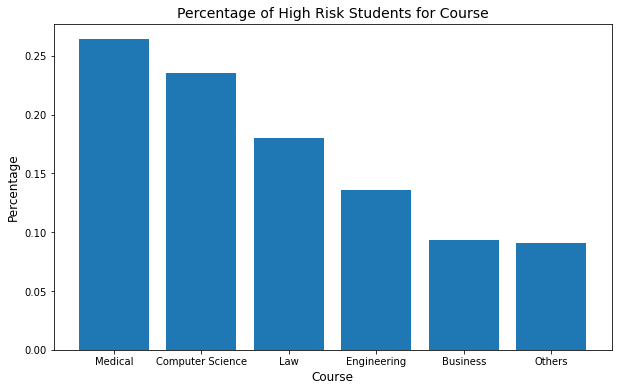

Percentage Breakdown of Categories
Medical             0.299643
Law                 0.197427
Engineering         0.152538
Computer Science    0.146104
Business            0.102216
Others              0.102073
Name: Course, dtype: float64

None
Gender


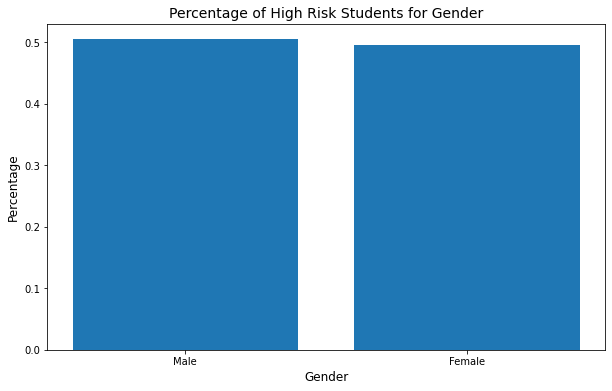

Percentage Breakdown of Categories
Male      0.505504
Female    0.494496
Name: Gender, dtype: float64

None
CGPA


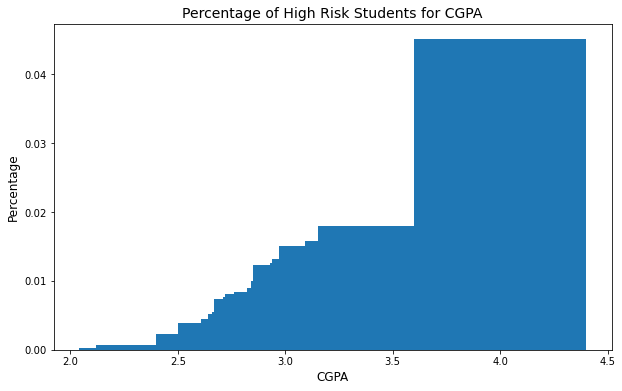

Percentage Breakdown of Categories
4.00    0.047462
3.51    0.015154
3.58    0.015154
3.55    0.015011
3.50    0.014725
          ...   
2.67    0.000143
2.44    0.000143
2.63    0.000143
2.58    0.000143
2.49    0.000143
Name: CGPA, Length: 143, dtype: float64

None
Stress_Level


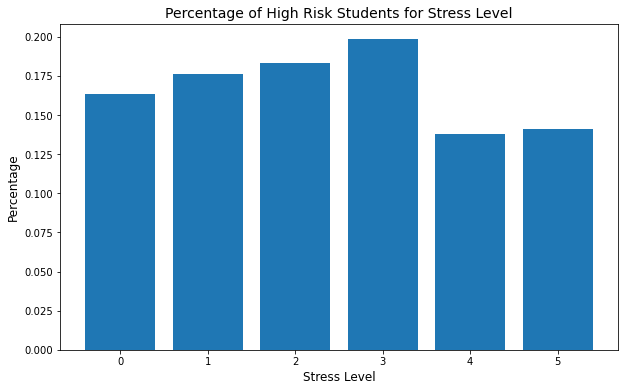

Percentage Breakdown of Categories
3    0.199714
2    0.182130
1    0.175268
0    0.156397
5    0.144818
4    0.141673
Name: Stress_Level, dtype: float64

None
Anxiety_Score


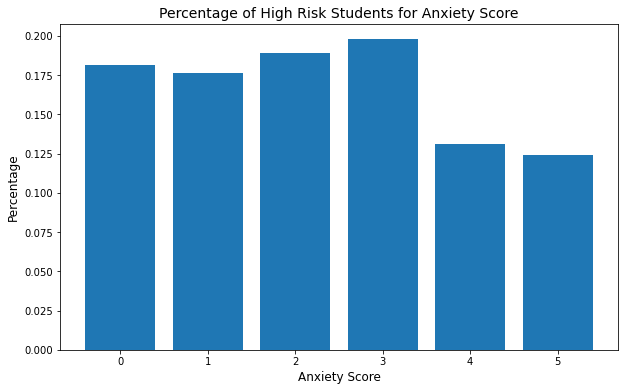

Percentage Breakdown of Categories
3    0.203431
2    0.184846
1    0.181129
0    0.176412
4    0.129664
5    0.124518
Name: Anxiety_Score, dtype: float64

None
Sleep_Quality


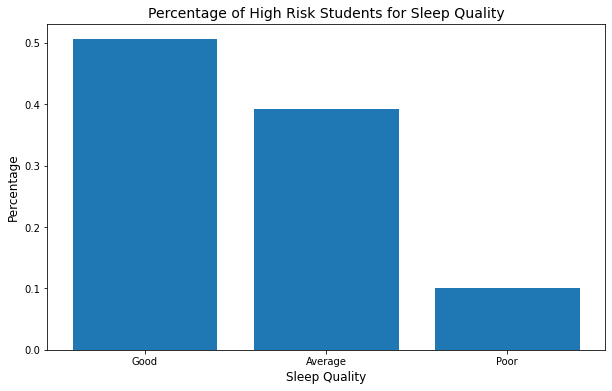

Percentage Breakdown of Categories
Good       0.511651
Average    0.388992
Poor       0.099357
Name: Sleep_Quality, dtype: float64

None
Physical_Activity


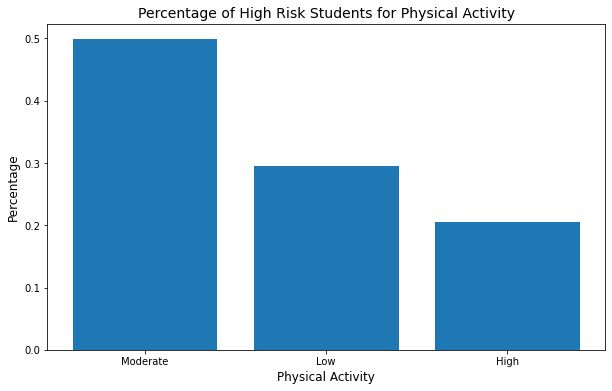

Percentage Breakdown of Categories
Moderate    0.501072
Low         0.298070
High        0.200858
Name: Physical_Activity, dtype: float64

None
Diet_Quality


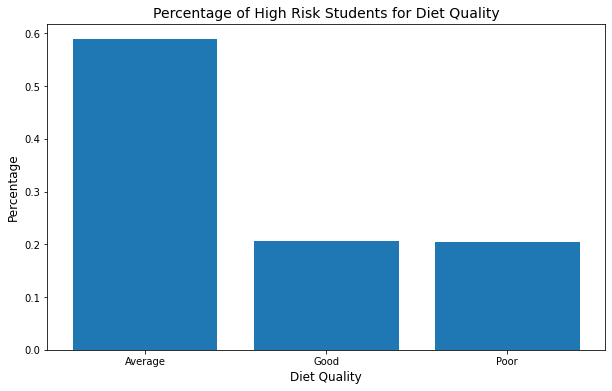

Percentage Breakdown of Categories
Average    0.608006
Good       0.197141
Poor       0.194853
Name: Diet_Quality, dtype: float64

None
Social_Support


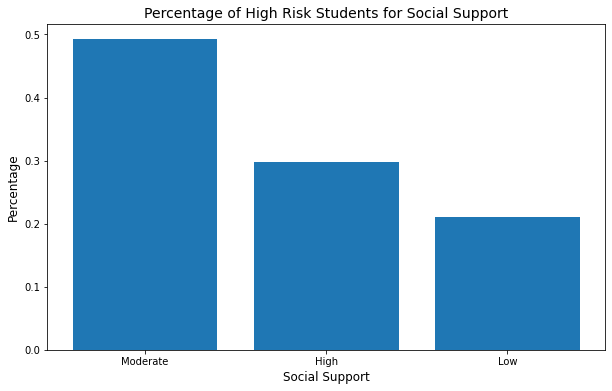

Percentage Breakdown of Categories
Moderate    0.494210
High        0.309507
Low         0.196283
Name: Social_Support, dtype: float64

None
Relationship_Status


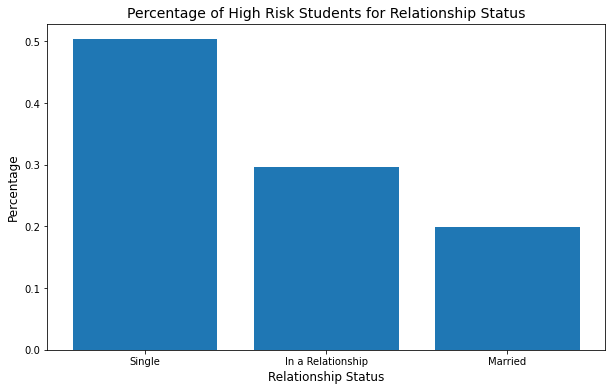

Percentage Breakdown of Categories
Single               0.509221
In a Relationship    0.295783
Married              0.194996
Name: Relationship_Status, dtype: float64

None
Substance_Use


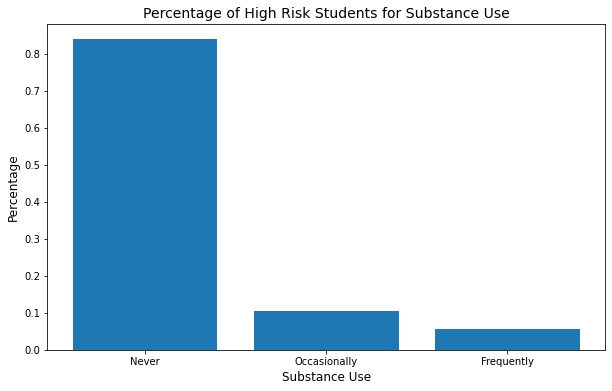

Percentage Breakdown of Categories
Never           0.842602
Occasionally    0.099643
Frequently      0.057756
Name: Substance_Use, dtype: float64

None
Counseling_Service_Use


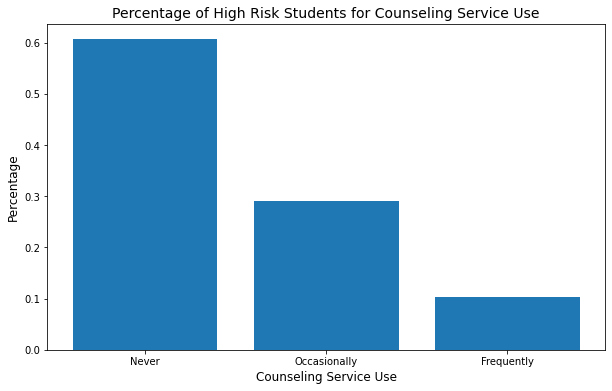

Percentage Breakdown of Categories
Never           0.607577
Occasionally    0.295783
Frequently      0.096640
Name: Counseling_Service_Use, dtype: float64

None
Family_History


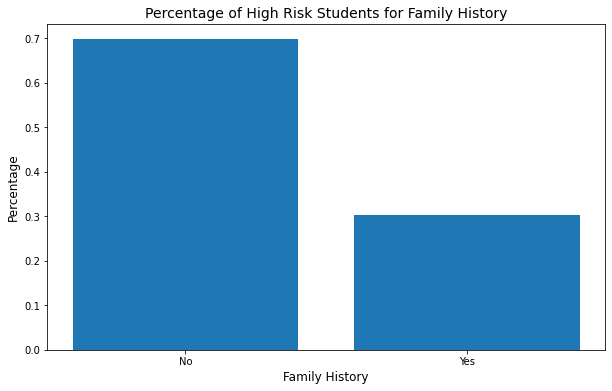

Percentage Breakdown of Categories
No     0.692495
Yes    0.307505
Name: Family_History, dtype: float64

None
Chronic_Illness


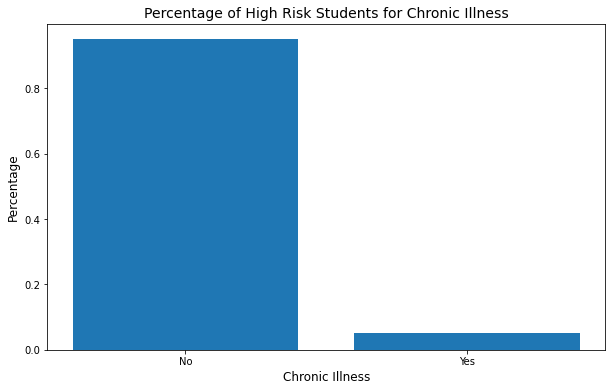

Percentage Breakdown of Categories
No     0.950965
Yes    0.049035
Name: Chronic_Illness, dtype: float64

None
Financial_Stress


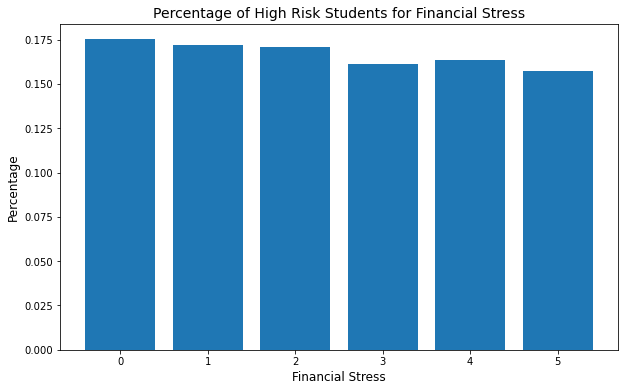

Percentage Breakdown of Categories
0    0.175125
1    0.168835
2    0.166976
4    0.165261
3    0.164689
5    0.159114
Name: Financial_Stress, dtype: float64

None
Extracurricular_Involvement


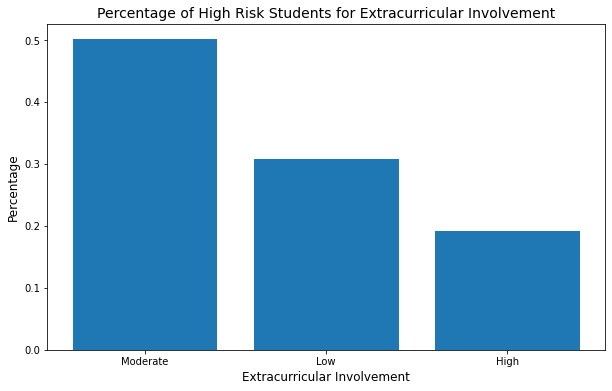

Percentage Breakdown of Categories
Moderate    0.489778
Low         0.308363
High        0.201858
Name: Extracurricular_Involvement, dtype: float64

None
Semester_Credit_Load


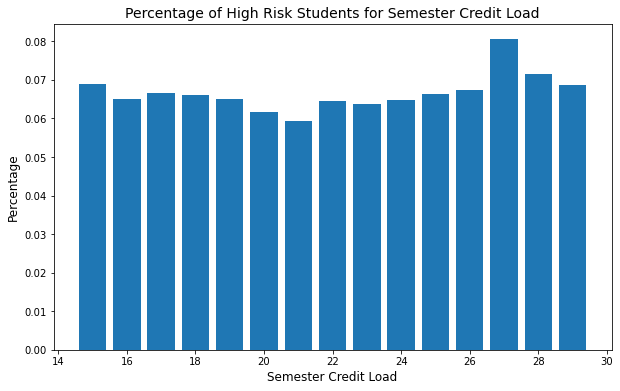

Percentage Breakdown of Categories
27    0.073052
17    0.072337
28    0.070050
15    0.067334
18    0.066762
19    0.066619
16    0.066476
24    0.066190
29    0.065761
25    0.065475
26    0.065046
22    0.065046
23    0.063760
21    0.063331
20    0.062759
Name: Semester_Credit_Load, dtype: float64

None
Residence_Type


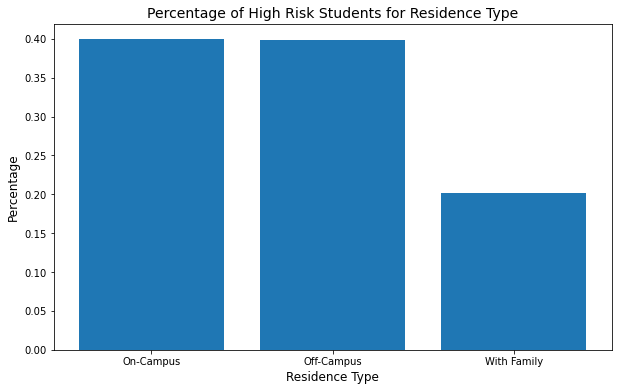

Percentage Breakdown of Categories
On-Campus      0.401001
Off-Campus     0.396569
With Family    0.202430
Name: Residence_Type, dtype: float64

None
Depression_Binary


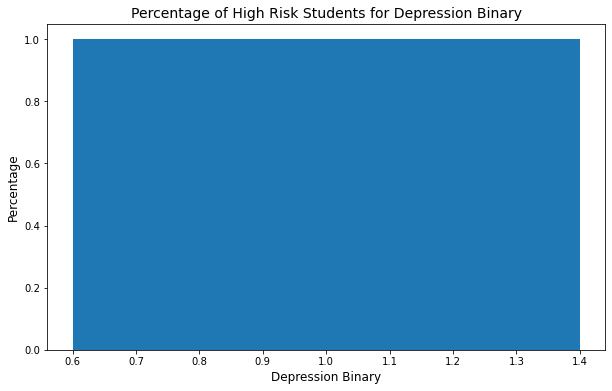

Percentage Breakdown of Categories
0.0    0.556254
1.0    0.443746
Name: Depression_Binary, dtype: float64

None


In [28]:
# Create a graph for every column
for column in df.columns:
    print(column)
    print(plot_hr_column_perc(column));

To see a better picture of the spread of high risk students by the category in each column, I decided to make a visual of the percentage of each category's high risk students. Many categories above could be misleading because it is based on count instead of percentage. For example, very few students are high risk who live with their family, but living with family is also the smallest subset of students in the dataset. In order to get a better picture of how living with family affected risk of depression, I would prefer to see the risk breakdown of the percentage of students who live at home. 

In [29]:
# Create bar chart of high risk students - percentage breakdown by column category
def plot_hr_perc(column):

    # Obtain percentage values for each ket in the category
    perc = df[column].loc[df['Depression_Binary']==1].value_counts() / df[column].value_counts()
    
    # Create empty lists for x and y to hold the keys and values
    x = []
    y = []

    # Assign keys and values to x and y respectively
    for key, value in perc.items():
        if type(key) == 'string':
            visual_key = key.replace('_', ' ')
            x.append(visual_key)
            y.append(value)
        else:
            x.append(key)
            y.append(value)
    
   # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x, y)

     # Set the title and axis labels
    plt.title(f"Percentage of High Risk Students by {column.replace('_', ' ')}", fontsize=14)
    plt.xlabel(column.replace('_',' '), fontsize=12)
    plt.ylabel(f"Percentage", fontsize=12)

    # Show the plot
    plt.show()
    print('Percentage Breakdown of Categories')
    print(df[column].value_counts(normalize=True))
    print()

The graphs below show the percentage of students that are high risk for each category in each column. Most column categories have a fairly even spread. For example, the Stress Level graph shows that just under 50% of students with stress levels of 0 are high risk for Depression. However, the graph also shows that for stress levels of 1 through 5, meaning that stress levels are not a good indicator for risk of depression. Surpisingly, it is the same story for Age, Anxiety, Sleep, Physical Activity, Diet, Social Support, Relationship Status, Substance Use, Counseling Service Use, Family History, Chronic Illness, Extracurricular Involvement, Semester Credit Load and Residence Type. 

The column that does stand out as having some correlation with high risk is Course. According to the graph, out of all computer science majors who completed this survey, about 70% of them were high risk for depression, while all other courses were around 40%. 

Another strange one to see is the Financial Stress. According to this graph, students with 0, 1, or 2 as their financial stress are more likely to be higher risk for depression than those at 3 and above. This is contradictory to common sense and made me wonder how honest these survey responses were.

Age


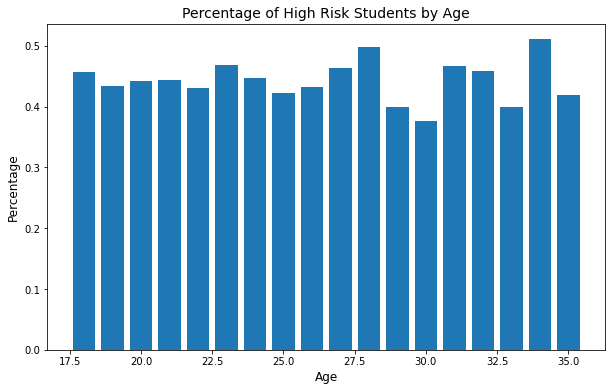

Percentage Breakdown of Categories
21    0.110936
18    0.105075
20    0.103074
19    0.101215
22    0.098642
23    0.091065
24    0.076769
26    0.064904
25    0.064904
27    0.046176
28    0.036741
29    0.026876
30    0.023159
31    0.017727
32    0.014010
33    0.007863
34    0.006433
35    0.004432
Name: Age, dtype: float64

None
Course


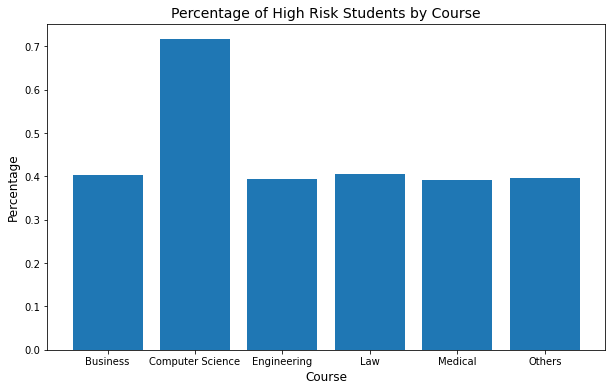

Percentage Breakdown of Categories
Medical             0.299643
Law                 0.197427
Engineering         0.152538
Computer Science    0.146104
Business            0.102216
Others              0.102073
Name: Course, dtype: float64

None
Gender


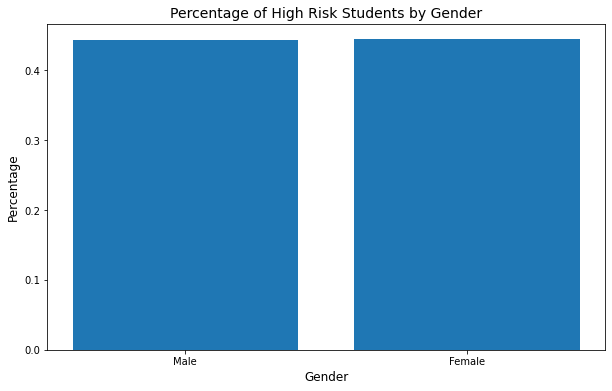

Percentage Breakdown of Categories
Male      0.505504
Female    0.494496
Name: Gender, dtype: float64

None
CGPA


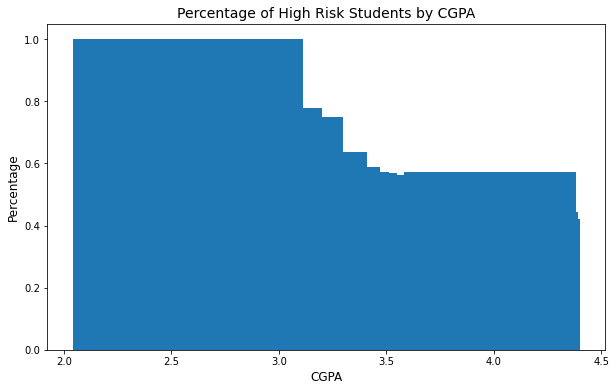

Percentage Breakdown of Categories
4.00    0.047462
3.51    0.015154
3.58    0.015154
3.55    0.015011
3.50    0.014725
          ...   
2.67    0.000143
2.44    0.000143
2.63    0.000143
2.58    0.000143
2.49    0.000143
Name: CGPA, Length: 143, dtype: float64

None
Stress_Level


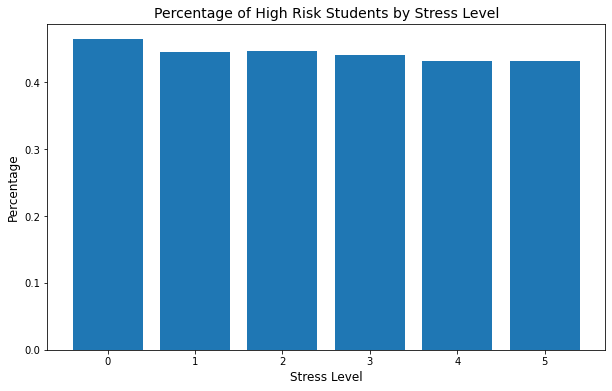

Percentage Breakdown of Categories
3    0.199714
2    0.182130
1    0.175268
0    0.156397
5    0.144818
4    0.141673
Name: Stress_Level, dtype: float64

None
Anxiety_Score


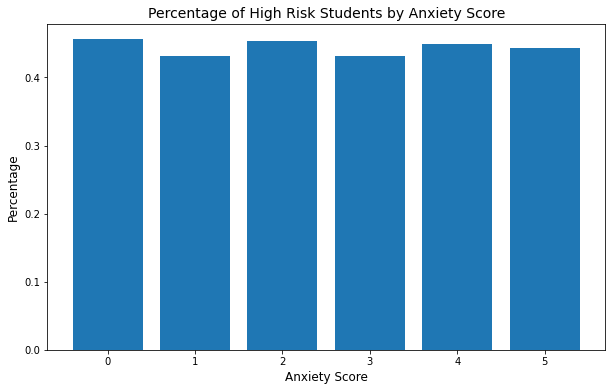

Percentage Breakdown of Categories
3    0.203431
2    0.184846
1    0.181129
0    0.176412
4    0.129664
5    0.124518
Name: Anxiety_Score, dtype: float64

None
Sleep_Quality


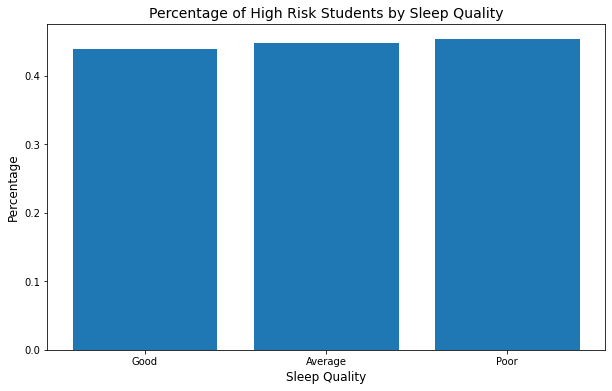

Percentage Breakdown of Categories
Good       0.511651
Average    0.388992
Poor       0.099357
Name: Sleep_Quality, dtype: float64

None
Physical_Activity


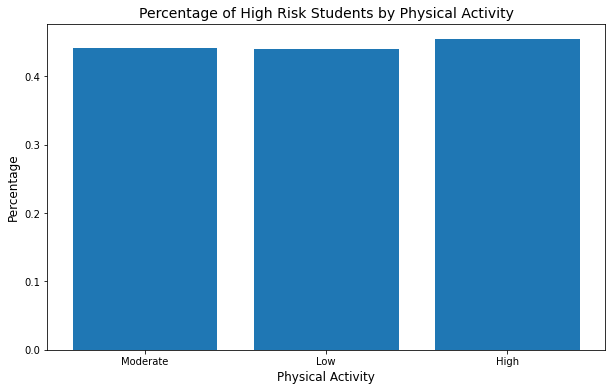

Percentage Breakdown of Categories
Moderate    0.501072
Low         0.298070
High        0.200858
Name: Physical_Activity, dtype: float64

None
Diet_Quality


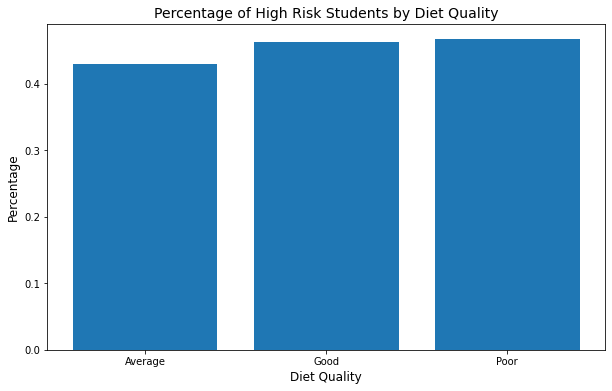

Percentage Breakdown of Categories
Average    0.608006
Good       0.197141
Poor       0.194853
Name: Diet_Quality, dtype: float64

None
Social_Support


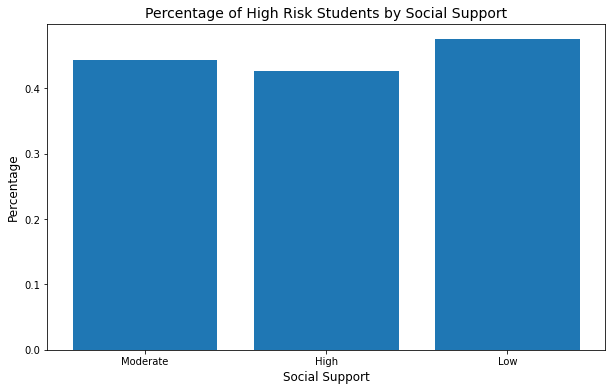

Percentage Breakdown of Categories
Moderate    0.494210
High        0.309507
Low         0.196283
Name: Social_Support, dtype: float64

None
Relationship_Status


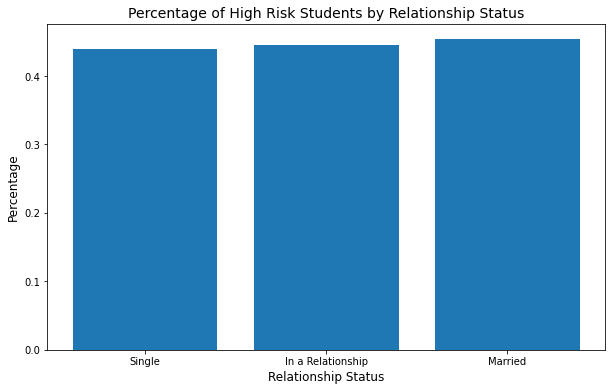

Percentage Breakdown of Categories
Single               0.509221
In a Relationship    0.295783
Married              0.194996
Name: Relationship_Status, dtype: float64

None
Substance_Use


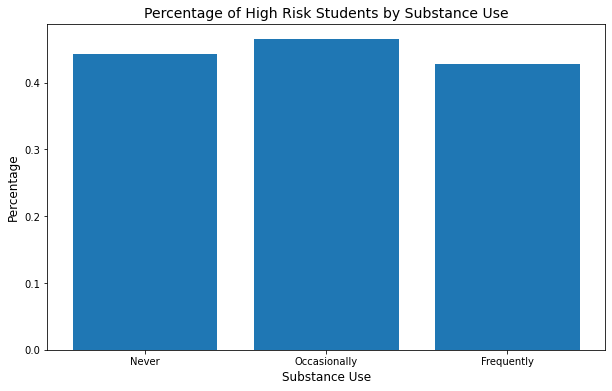

Percentage Breakdown of Categories
Never           0.842602
Occasionally    0.099643
Frequently      0.057756
Name: Substance_Use, dtype: float64

None
Counseling_Service_Use


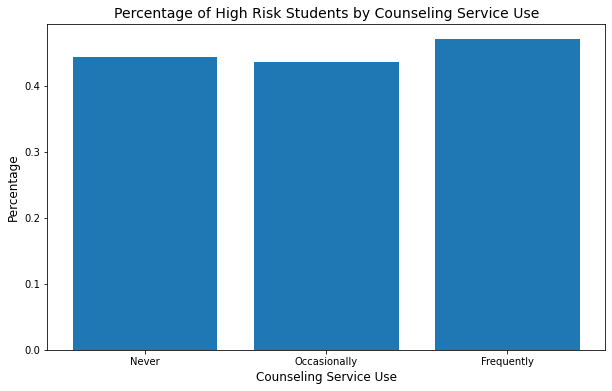

Percentage Breakdown of Categories
Never           0.607577
Occasionally    0.295783
Frequently      0.096640
Name: Counseling_Service_Use, dtype: float64

None
Family_History


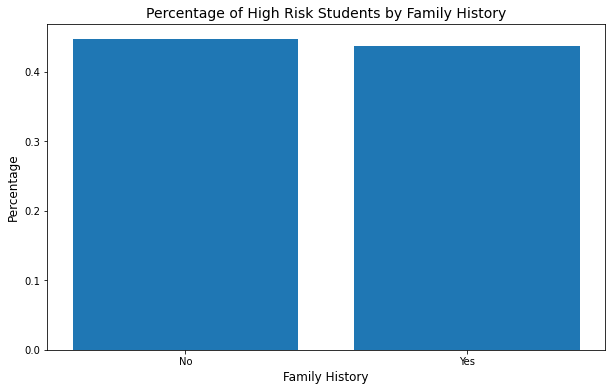

Percentage Breakdown of Categories
No     0.692495
Yes    0.307505
Name: Family_History, dtype: float64

None
Chronic_Illness


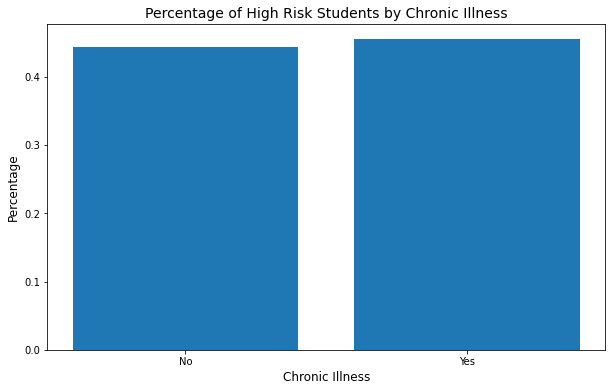

Percentage Breakdown of Categories
No     0.950965
Yes    0.049035
Name: Chronic_Illness, dtype: float64

None
Financial_Stress


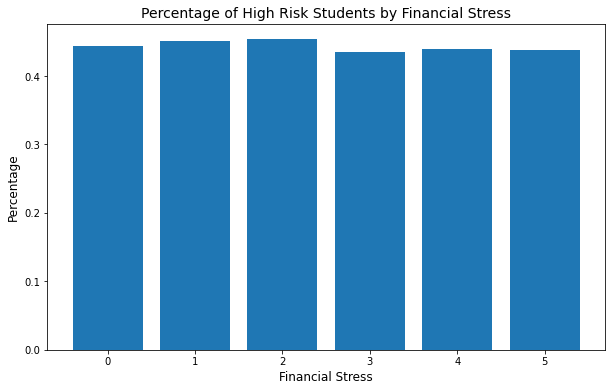

Percentage Breakdown of Categories
0    0.175125
1    0.168835
2    0.166976
4    0.165261
3    0.164689
5    0.159114
Name: Financial_Stress, dtype: float64

None
Extracurricular_Involvement


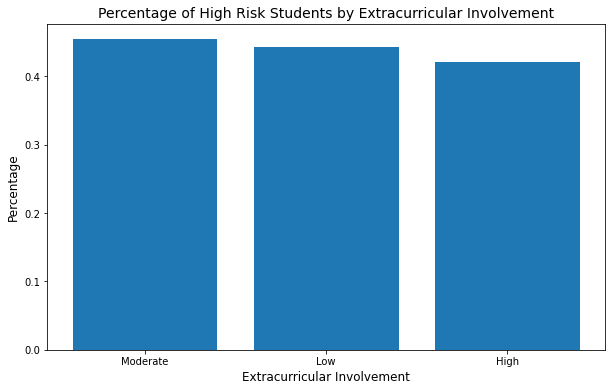

Percentage Breakdown of Categories
Moderate    0.489778
Low         0.308363
High        0.201858
Name: Extracurricular_Involvement, dtype: float64

None
Semester_Credit_Load


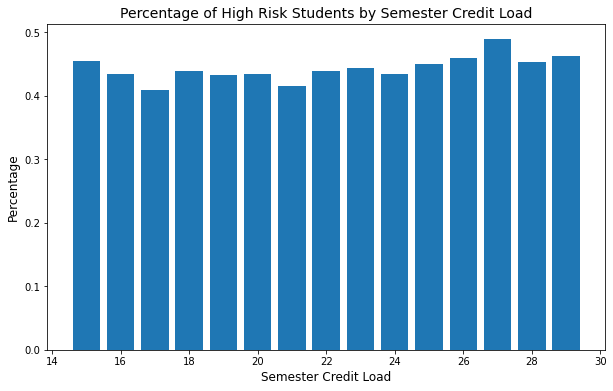

Percentage Breakdown of Categories
27    0.073052
17    0.072337
28    0.070050
15    0.067334
18    0.066762
19    0.066619
16    0.066476
24    0.066190
29    0.065761
25    0.065475
26    0.065046
22    0.065046
23    0.063760
21    0.063331
20    0.062759
Name: Semester_Credit_Load, dtype: float64

None
Residence_Type


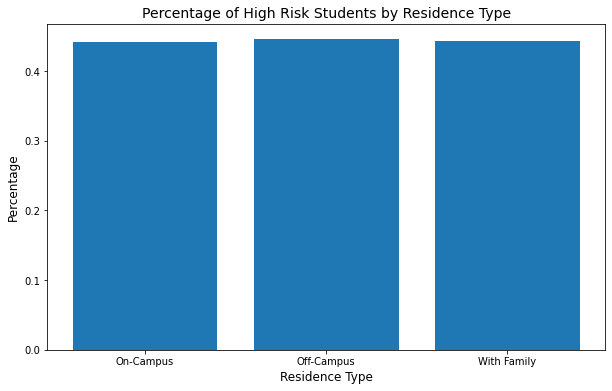

Percentage Breakdown of Categories
On-Campus      0.401001
Off-Campus     0.396569
With Family    0.202430
Name: Residence_Type, dtype: float64

None
Depression_Binary


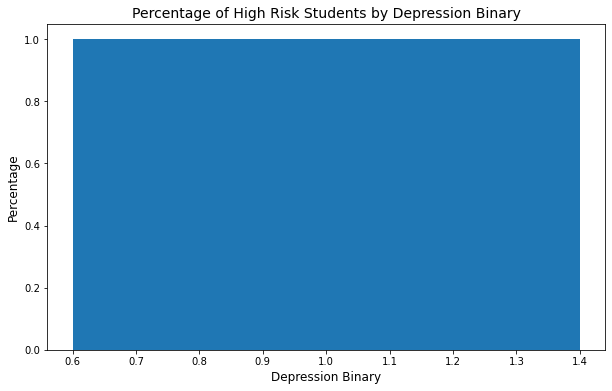

Percentage Breakdown of Categories
0.0    0.556254
1.0    0.443746
Name: Depression_Binary, dtype: float64

None


In [30]:
# Create a graph for every column
for column in df.columns:
    print(column)
    print(plot_hr_perc(column));

Based on the above graphs, I was not hopeful that my model would be able to perform very well. With almost no sepcific correlations, it will be very difficult for the model to find a pattern and be able to discern a student who is high or low risk.

### Preprocessing Data

The following numerical columns were scaled:
* Age, Semester Credit Load, CGPA <br>
These columns had numerical, continuous values. 

The following categorical columns were one-hot encoded:
* Course, Gender, Relationship Status, Family History, Residence Type, Chronic Illness <br>
These columns had categorical values with no rank or order.

The following hierarchical categorical columns were ordinal encoded:
* Sleep Quality, Physical Activity, Diet Quality, Social Support, Substance Use, Counseling Service Use, Extracurricular Involvement <br>
These columns had hierarchical categories that had an inherent order. 
For example, Sleep Quality was either 'Poor', 'Average', or 'Good' and Social Support was either 'Low', 'Moderate', or 'High'. 

In [31]:
# Define columns for scaling, one hot encoding, and ordinal encoding
continuous_cols = ['Age', 'Semester_Credit_Load', 'CGPA']
ohe_cols = ['Course', 'Gender', 'Relationship_Status', 'Family_History', 'Residence_Type', 'Chronic_Illness']
ordinal_cols = ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Substance_Use', 
               'Counseling_Service_Use', 'Extracurricular_Involvement']

# Order Ordinal Column Entries
sleep_ord = ['Poor', 'Average', 'Good']
phys_ord = ['Low', 'Moderate', 'High']
diet_ord = ['Poor', 'Average', 'Good']
social_ord = ['Low', 'Moderate', 'High']
subst_ord = ['Never', 'Occasionally', 'Frequently']
counsel_ord = ['Never', 'Occasionally', 'Frequently']
extracurric_ord = ['Low', 'Moderate', 'High']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('num', StandardScaler(), continuous_cols),  
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
        ('ord', OrdinalEncoder(categories=[sleep_ord, phys_ord, diet_ord, 
                                           social_ord, subst_ord, counsel_ord, extracurric_ord]), 
         ordinal_cols)])

Once all the actions above were completed, the data was ready for a train/test split in order to begin the modeling process.

In [32]:
y = df.pop('Depression_Binary')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333)

In [33]:
X_train

,Age,Course,Gender,CGPA,Stress_Level,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
4584,21,Engineering,Female,3.08,0,3,Good,Low,Good,High,Married,Never,Never,Yes,No,1,High,17,With Family
118,23,Engineering,Female,3.10,0,0,Good,High,Good,High,Married,Never,Never,No,No,0,Moderate,16,On-Campus
311,22,Business,Female,3.65,2,2,Good,Moderate,Poor,Moderate,Single,Never,Never,No,No,4,Moderate,20,Off-Campus
4537,24,Engineering,Male,3.44,5,3,Average,Moderate,Average,Low,In a Relationship,Never,Never,No,No,5,Moderate,29,Off-Campus
4389,26,Law,Male,3.36,1,0,Poor,Moderate,Average,Moderate,Single,Never,Never,Yes,No,0,Low,28,On-Campus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,22,Medical,Female,3.07,1,5,Average,Low,Average,High,Single,Never,Never,No,No,5,Moderate,19,With Family
6076,25,Business,Female,3.63,1,3,Good,Low,Average,Low,Single,Never,Never,Yes,No,1,Moderate,16,Off-Campus
1452,25,Law,Male,3.25,2,5,Good,Low,Average,Moderate,Single,Never,Occasionally,Yes,Yes,5,Low,17,On-Campus
982,23,Engineering,Female,3.73,2,3,Average,Moderate,Poor,Low,Married,Never,Never,Yes,No,4,Low,22,With Family


In [34]:
y_train.value_counts()

0.0    2940
1.0    2306
Name: Depression_Binary, dtype: int64

In [35]:
# Confirming preprocessor outputs correct number of rows of data
preprocessor.fit_transform(X_train).shape

(5246, 31)

## Modeling

In order to analyze the performance of the models I built, I focused on recall. This model could be used at schools to help determine which students may need additional support in and out of the classroom. I decided it was best to minimize false negatives (saying a student is less likely to have depression when they are actually more likely), because that would be neglecting to offer additional support when it is needed. A false positive on the other hand, would be a small cost to the school, but ultimately would just give more support to a student, which is never a bad thing. 

For this problem I needed to use classification models. There are many options to use and I wasn't sure which would be most appropriate so I created a wide variety. First, I started with a decision tree purposefully trying to overfit the model to confirm that we had the right data in order to build a successful predictive model. After then reducing the overfitting, I then tried Random Forest, Logistic Regression, and finally a Gradient Boosting Classifier.

Note: All of the models created below (except the Dummy Model) utilize a pipeline that includes the preprocessing steps listed earlier in this notebook in order to avoid data leakage.

## Evaluation

In order to evaluate the models consistently, I created a function that would show each model's cross validation and training scores for recall and accuracy. It also showed a confusion matrix for a visual of a breakdown of the model's predictions. While both scores were useful for the interpretation of the model, the tweaking of the models were to improve the recall score. 

In [36]:
# Defining scorers to evaluate models
recall_scorer = make_scorer(recall_score)

This function compares the model's performance on training data to the model's performance with cross validation.

In [37]:
# Compare training and cross validation scores
def cv_scores(model):
        
    # Define the predictions from the Pipeline using the training data
    y_pred = model.predict(X_train)
    
    # Evaluate the scores 
    print('Train Recall: ', recall_score(y_train, y_pred))
    print('CV Recall: ', cross_val_score(model, X_train, y_train, scoring=recall_scorer).mean())
    print('')
    print('Train Accuracy: ', accuracy_score(y_train, y_pred))
    print('CV Accuracy: ', cross_val_score(model, X_train, y_train).mean())
    
    
    # Creating confusion matrix
    cf = confusion_matrix(y_train, y_pred)
    # Displaying confusion matrix
    ConfusionMatrixDisplay(cf, display_labels=['Low Risk', 'High Risk']).plot(cmap='YlGnBu')

All of the models I experimented with were tweaked using Grid Search. I created the function below to consistently evaluate each iteration for each model. 

In [38]:
# Produce grid search's best estimator, best score, and compare training and cross validation scores
def grid_results(model):
    print("Recall")
    print(model)
    print('')
    
    # Defining the predictions from the Pipeline using the training data
    y_pred = model.predict(X_train)
    
    # Evaluating the scores 
    print('Best Estimator Scores:')
    print('Train Recall: ', recall_score(y_train, y_pred))
    print('CV Recall: ', cross_val_score(model, X_train, y_train, scoring=recall_scorer).mean())    
    print('')
    print('Train Accuracy: ', accuracy_score(y_train, y_pred))
    print('CV Accuracy: ', cross_val_score(model, X_train, y_train).mean())
   
    print('')
    print('Best Estimator Confusion Matrix on Training Data with no CV')
    # Creating confusion matrix
    cf = confusion_matrix(y_train, y_pred)
    # Displaying confusion matrix
    ConfusionMatrixDisplay(cf, display_labels=['Low Risk', 'High Risk']).plot(cmap='YlGnBu')

The first model I made was a Dummy Model. This model predicts 1 every single time and thus, has a perfect recall score.

### Dummy Model Classifier

In [39]:
# Instantiate dummy model that will always predict Yes
dummy_model = DummyClassifier(strategy="constant", constant=1)
dummy_model.fit(X_train, y_train)

# Pickle the model
with open('pickled_models/dummy_model.pkl', 'wb') as f:
    pickle.dump(dummy_model, f)

In [40]:
# Load the pickled model
with open('pickled_models/dummy_model.pkl', 'rb') as f:
    dummy_model = pickle.load(f)

This model's recall score was 100% but it's accuracy score was only 43%. My goal was to create a model that had a recall score over 50% and a better Accuracy score than the Dummy Model. 

Train Recall:  1.0
CV Recall:  1.0

Train Accuracy:  0.4395730080060999
CV Accuracy:  0.43957292659675884


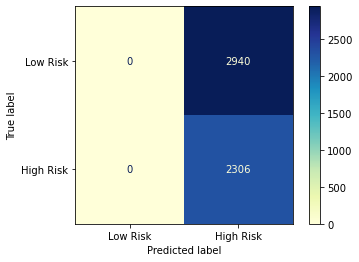

In [41]:
# Cross Validation Scores
cv_scores(dummy_model)

### First Model: Decision Tree 

The first model I created was a decision tree with all default parameters. My goal here was to purposefully create an overfit model in order to confirm it achieves a high recall score. Accomplishing this shows that I am using good enough data in order to predict the target variable.

In [42]:
# # Creating steps for a Pipeline 
# tree_steps = [('preprocess', preprocessor),
#               ('tree', DecisionTreeClassifier())]

# # Feeding the Pipeline the steps defined above
# tree_pipe = Pipeline(tree_steps)

# # Fitting the training data to the Pipeline
# tree_pipe.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/tree_pipe.pkl', 'wb') as f:
#     pickle.dump(tree_pipe, f)

In [43]:
# Load the pickled model
with open('pickled_models/tree_pipe.pkl', 'rb') as f:
    tree_pipe = pickle.load(f)

This worked successfully, this model received a recall score of 100% on the training data but below 50% on the cross validation, showing this model is very overfit. 

Train Recall:  1.0
CV Recall:  0.4592435041458903

Train Accuracy:  1.0
CV Accuracy:  0.5160152526215442


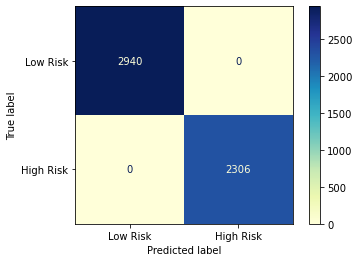

In [44]:
# Cross Validation Scores
cv_scores(tree_pipe)

### Second Model: Random Forest

The decision tree certainly held promise, so I decided to use a random forest which would be able to combine the power of many decision trees. I first created a random forest model with default parameters.

In [45]:
# # Creating steps for a Pipeline 
# forest_steps = [('preprocess', preprocessor),
#                 ('forest', RandomForestClassifier(random_state=333))]

# # Feeding the Pipeline the steps defined above
# forest_pipe = Pipeline(forest_steps)

# # Fitting the training data to the Pipeline
# forest_pipe.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/forest_pipe.pkl', 'wb') as f:
#     pickle.dump(forest_pipe, f)

In [46]:
# Load the pickled model
with open('pickled_models/forest_pipe.pkl', 'rb') as f:
    forest_pipe = pickle.load(f)

This model is even more overfit than the Decision Tree. Tuning the parameters should be able to adjust that. 

Train Recall:  1.0
CV Recall:  0.30399188663830745

Train Accuracy:  1.0
CV Accuracy:  0.5947385718825184


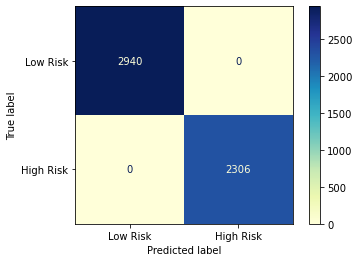

In [47]:
# Evaluate the model
cv_scores(forest_pipe)

#### Random Forest with Grid Search 1

In order to combat the overfit results I used a GridSearch to help tune the hyperparameters.


In [48]:
# # Creating parameters for GridSearch
# params = {'forest__n_estimators': [50, 100, 150],
#           'forest__criterion': ['gini', 'entropy'],
#           'forest__max_depth': [10, None],
#           'forest__min_samples_split': [2],
#           'forest__min_weight_fraction_leaf': [0, .5],
#           'forest__max_features': ['auto', None, 15],
#           'forest__max_leaf_nodes': [None, 10],
#           'forest__min_impurity_decrease': [0, .5],
#          }

# # GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
# forest_grid1 = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# forest_grid1.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/forest_grid1_best.pkl', 'wb') as f:
#     pickle.dump(forest_grid1.best_estimator_, f)

In [49]:
# Load the pickled model
with open('pickled_models/forest_grid1_best.pkl', 'rb') as f:
    forest_grid1_best = pickle.load(f)

This has a slightly better recall score than the default Random Forest but is still very overfit. 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

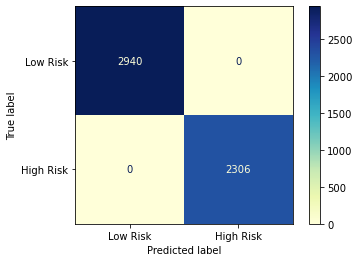

In [50]:
# Evaluate the model
grid_results(forest_grid1_best)

Hyperparameter Updates:
- n_estimators selected 50 so I provided more options around 50.
- criterion selcted 'gini' so I kept it as 'gini'.
- max_depth was None so I gave two more options for larger max_depth.
- min_samples_split was kept as default 2 last time so now I gave the option of 3.
- min_weight_fraction_leaf was selected as 0 so I offered more options closer to 0.
- max_features was selected as 15 so I narrowed the scope of options to be around 15.
- max_leaf_nodes was selected as None so I adjusted the option from 10 to 20.
- min_impurity_decrease was selected as 0 so I dropped the other option from .5 to .25.

#### Random Forest with Grid Search 2

In [51]:
# # Creating parameters for GridSearch
# params = {'forest__n_estimators': [50, 100, 40, 60],
#           'forest__criterion': ['gini'],
#           'forest__max_depth': [30, 100, None],
#           'forest__min_samples_split': [3, 2],
#           'forest__min_weight_fraction_leaf': [0, .75, .5, .25],
#           'forest__max_features': [15, 20, 10, 'auto'],
#           'forest__max_leaf_nodes': [None, 20],
#           'forest__min_impurity_decrease': [0, .25],
#          }

# # GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
# forest_grid2 = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# forest_grid2.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/forest_grid2_best.pkl', 'wb') as f:
#     pickle.dump(forest_grid2.best_estimator_, f)

In [52]:
# Load the pickled model
with open('pickled_models/forest_grid2_best.pkl', 'rb') as f:
    forest_grid2_best = pickle.load(f)

This has a slightly better recall score but is still very overfit. 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

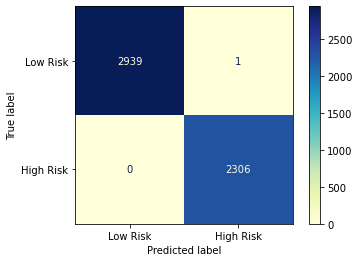

In [53]:
grid_results(forest_grid2_best)

Hyperparameter Updates:
- n_estimators selected 40 so I kept it there to further analyze other hyperparameters.
- criterion stayed at 'gini'.
- max_depth was 30 instead of None or 100 so I gave it 60 to see which of those two it would take.
- min_samples_split was 3 so now I gave the option of 4 because it increased from 2.
- min_weight_fraction_leaf was again selected as 0 so I stayed at 0.
- max_features was selected as 15 so I kept it at 15 but also gave the option of None.
- max_leaf_nodes was selected as None so I drastically increased the options to see if a larger number would take.
- min_impurity_decrease was only given at 0 and I stayed with that.

#### Random Forest with Grid Search 3

In [54]:
# # Creating parameters for GridSearch
# params = {'forest__n_estimators': [40],
#           'forest__criterion': ['gini'],
#           'forest__max_depth': [30, 60],
#           'forest__min_samples_split': [3, 4],
#           'forest__min_weight_fraction_leaf': [0],
#           'forest__max_features': [15, None],
#           'forest__max_leaf_nodes': [100, 500, None, 300, 1000],
#           'forest__min_impurity_decrease': [0],
#          }

# # GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
# forest_grid3 = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# forest_grid3.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/forest_grid3_best.pkl', 'wb') as f:
#     pickle.dump(forest_grid3.best_estimator_, f)

In [55]:
# Load the pickled model
with open('pickled_models/forest_grid3_best.pkl', 'rb') as f:
    forest_grid3_best = pickle.load(f)

This cross validation recall score barely improved and the model is still overfit.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

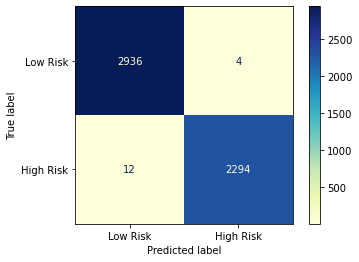

In [56]:
grid_results(forest_grid3_best)

The recall score increased a bit but the accuracy decreased. While there was much more tweaking to be done on this model, I decided to use a Gradient Boosting Classifier (shown further down) to continue this plunge because that is also a tree-based model. 

For now, I decided to get a peak at what a Logistic Regression model looked like.

### Third Model: Logistic Regression

Created a Logistic Regression model with default parameters.

In [57]:
# # Creating steps for a Pipeline 
# logreg_steps = [('preprocess', preprocessor),
#                 ('logreg', LogisticRegression(random_state=333))]

# # Feeding the Pipeline the steps defined above
# logreg_pipe = Pipeline(logreg_steps)

# # Fitting the training data to the Pipeline
# logreg_pipe.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logreg_pipe.pkl', 'wb') as f:
#     pickle.dump(logreg_pipe, f)

In [58]:
# Load the pickled model
with open('pickled_models/logreg_pipe.pkl', 'rb') as f:
    logreg_pipe = pickle.load(f)

The model does not appear to be overfit, but it is extremely underfit. 

Train Recall:  0.2341717259323504
CV Recall:  0.23460855846972986

Train Accuracy:  0.6212352268394967
CV Accuracy:  0.6210449861546145


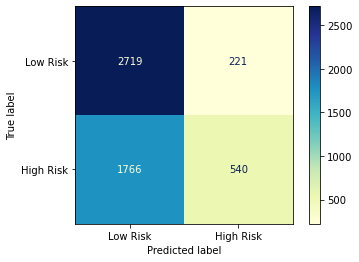

In [59]:
cv_scores(logreg_pipe)

My first goal was to make the model overfit to ensure that the data could be used in a meaningful way by the model.

#### Logistic Regression with Grid Search 1

Tried to improve results with Grid Search.

In [60]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced', None],
#                 'logreg__C': [1, 0.0001],
#                 'logreg__solver': ['lbfgs', 'sag', 'saga'],
#                 'logreg__max_iter': [100],
#                 'logreg__penalty': ['l1', 'l2']}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# logreg_grid1 = GridSearchCV(estimator=logreg_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# logreg_grid1.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logreg_grid1_best.pkl', 'wb') as f:
#     pickle.dump(logreg_grid1.best_estimator_, f)

In [61]:
# Load the pickled model
with open('pickled_models/logreg_grid1_best.pkl', 'rb') as f:
    logreg_grid1_best= pickle.load(f)

The model successfully overfit and has the highest recall score of any model thus far! 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

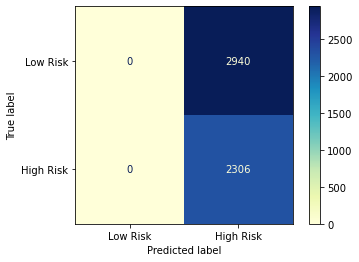

In [62]:
grid_results(logreg_grid1_best)

Tried to improve the results with another Grid Search.

Hyperparameter Updates:
- class_weight was selected as balanced so I kept it as that.
- C selected the lowest value with the most regularization so I gave it more lower options.
- solver was 'saga' but I still kept the other options in just in case.
- max_iter only had 100 as an option but now I gave it more options.
- penalty chose 'l1', implementing more regularizaiton, so I kept that and also gave two other options.

#### Logistic Regression with Grid Search 2

In [63]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced'],
#                 'logreg__C': [.0001, .00001, .001],
#                 'logreg__solver': ['saga', 'liblinear', 'newton-cg'],
#                 'logreg__max_iter': [50, 100, 150, 1000],
#                 'logreg__penalty': ['elasticnet', 'l1', None]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# logreg_grid2 = GridSearchCV(estimator=logreg_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# logreg_grid2.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logreg_grid2_best.pkl', 'wb') as f:
#     pickle.dump(logreg_grid2.best_estimator_, f)

In [64]:
# Load the pickled model
with open('pickled_models/logreg_grid2_best.pkl', 'rb') as f:
    logreg_grid2_best = pickle.load(f)

The grid search did not change any of the scores. 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

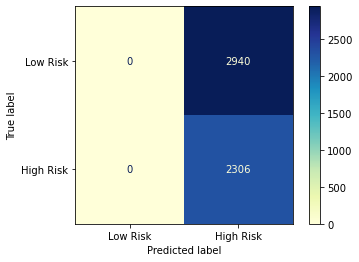

In [65]:
grid_results(logreg_grid2_best)

Hyperparameter Updates:
- class_weight was kept at balanced.
- C selected 0.001 so I gave one value closer to that and one higher in case the other variables drastically changed it.
- solver was 'saga' again so I only used that.
- max_iter selected 50 so I gave it a higher and lower option.
- penalty chose l1 again so I kept it at that.

#### Logistic Regression with Grid Search 3

Tried to improve results with Grid Search.

In [66]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced'],
#                 'logreg__C': [1, .01, .001],
#                 'logreg__solver': ['saga'],
#                 'logreg__max_iter': [25, 50, 75],
#                 'logreg__penalty': ['l1']}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# logreg_grid3 = GridSearchCV(estimator=logreg_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# logreg_grid3.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logreg_grid3_best.pkl', 'wb') as f:
#     pickle.dump(logreg_grid3.best_estimator_, f)

In [67]:
# Load the pickled model
with open('pickled_models/logreg_grid3_best.pkl', 'rb') as f:
    logreg_grid3_best = pickle.load(f)

This still did not change the scores in a meaningful way.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

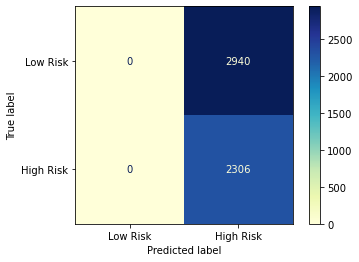

In [68]:
grid_results(logreg_grid3_best)

While the 60% recall score was good, the accuracy score was not where I wanted it. Because the initial Logistic Regression with default parameters was underfit, I decided to try adding polynomial features to increase complexity. 

### Fourth Model: Logistic Regression with Polynomial Features

In [69]:
# # Creating steps for a Pipeline 
# logregpoly_steps = [('preprocess', preprocessor),
#                 ('polynomials', PolynomialFeatures()),
#                 ('logreg', LogisticRegression(max_iter=1000, random_state=333))]

# # Feeding the Pipeline the steps defined above
# logregpoly_pipe = Pipeline(logregpoly_steps)

# # Fitting the training data to the Pipeline
# logregpoly_pipe.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logregpoly_pipe.pkl', 'wb') as f:
#     pickle.dump(logregpoly_pipe, f)

In [70]:
# Load the pickled model
with open('pickled_models/logregpoly_pipe.pkl', 'rb') as f:
    logregpoly_pipe = pickle.load(f)

This recall score was already better than the logistic regression with default parameters but was still very underfit. 

Train Recall:  0.4241110147441457
CV Recall:  0.3790123108995126

Train Accuracy:  0.6471597407548608
CV Accuracy:  0.5808209178809751


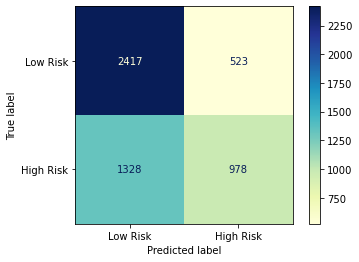

In [71]:
cv_scores(logregpoly_pipe)

My first goal was to make this model overfit so then I could fine tune it.

#### Logistic Regression with Polynomial Features with Grid Search 1

Tried to improve results with Grid Search.

In [72]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced', None],
#                 'logreg__C': [1, .01, .001],
#                 'logreg__solver': ['saga'],
#                 'logreg__max_iter': [1000, 2000],
#                 'logreg__penalty': ['l1', 'l2']}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# logregpoly_grid1 = GridSearchCV(estimator=logregpoly_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# logregpoly_grid1.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logregpoly_grid1_best.pkl', 'wb') as f:
#     pickle.dump(logregpoly_grid1.best_estimator_, f)

In [73]:
# Load the pickled model
with open('pickled_models/logregpoly_grid1_best.pkl', 'rb') as f:
    logregpoly_grid1_best = pickle.load(f)

This model is much better on recall! It is overfit as I was aiming and it is the highest recall score I've gotten so far. Now I wanted to make it a bit less overfit and see if I can increase the accuracy score as well because right now it may just be choosing 'Yes' majority of the time, which maximizes recall, but is not very accurate.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

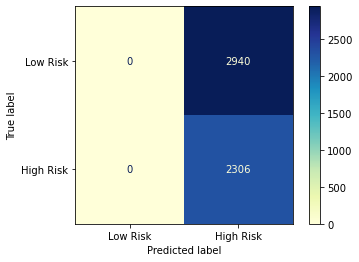

In [74]:
grid_results(logregpoly_grid1_best)

Hyperparameter Updates:
- class_weight was selected as balanced so I kept it as that.
- C selected the lowest value with the most regularization so I gave it another lower option.
- solver only had the option of saga so this time I gave it two more options.
- max_iter took the lower option so I gave it more lower options.
- penalty chose l1 so I also gave it an option of none.
- degree stayed at 2 for the polynomials.

#### Logistic Regression with Polynomial Features with Grid Search 2

Tried to improve results with GridSearch.

In [75]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced'],
#                 'logreg__C': [.001, .0001],
#                 'logreg__solver': ['saga', 'sag', 'lbfjs'],
#                 'logreg__max_iter': [600, 800, 1000],
#                 'logreg__penalty': ['l1', 'none']}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# logregpoly_grid2 = GridSearchCV(estimator=logregpoly_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)

# # Fitting the GridSearch
# logregpoly_grid2.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logregpoly_grid2_best.pkl', 'wb') as f:
#     pickle.dump(logregpoly_grid2.best_estimator_, f)

In [76]:
# Load the pickled model
with open('pickled_models/logregpoly_grid2_best.pkl', 'rb') as f:
    logregpoly_grid2_best = pickle.load(f)

This grid search resulted in the same cross validation scores for recall and accuracy. 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

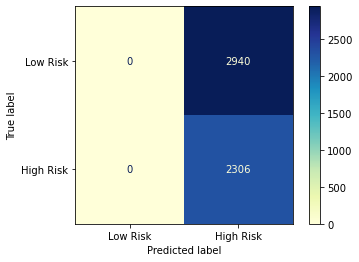

In [77]:
grid_results(logregpoly_grid2_best)

While the recall score is great, the accuracy is only about 2% better than my Dummy Model of predicting High Risk everytime. I decided to create a few Logistic Regression models focused on accuracy to see if that could potentially help.

#### Logistic Regression with Randomized Search (Accuracy) 1

In [78]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced', None],
#                 'logreg__C': [1, 0.01, 0.0001],
#                 'logreg__solver': ['liblinear','lbfgs', 'sag', 'saga'],
#                 'logreg__max_iter': [100, 50],
#                 'logreg__penalty': ['l1', 'l2', 'elasticnet', None]}

# # RandomizedSearch
# logreg_random1_acc = RandomizedSearchCV(estimator=logreg_pipe, param_distributions=params, cv=5, n_iter=50, n_jobs=3, random_state=333)

# # Fitting the GridSearch
# logreg_random1_acc.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logreg_random1_acc_best.pkl', 'wb') as f:
#     pickle.dump(logreg_random1_acc.best_estimator_, f)

In [79]:
# Load the pickled model
with open('pickled_models/logreg_random1_acc_best.pkl', 'rb') as f:
    logreg_random1_acc_best = pickle.load(f)

After the first RandomizedSearch the recall score is poor but the accuracy score is better. I decided to tweak the paramters to see if the scores could get better.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

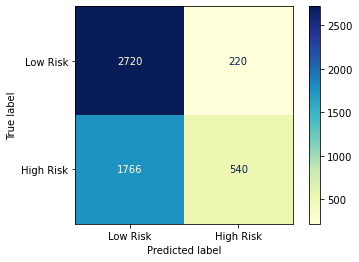

In [80]:
grid_results(logreg_random1_acc_best)

Hyperparameter Updates:
- class_weight was selected as balanced so I kept it as that.
- C selected the middle value so I gave it more options around that.
- solver selected liblinear but I kept the others just in case.
- max_iter selected 100 so I gave it more options around that.
- penalty chose l1, implementing more regularizaiton, but I kept the others just in case.

#### Logistic Regression with Randomized Search (Accuracy) 2

In [81]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced', None],
#                 'logreg__C': [.1, 0.01, 0.001],
#                 'logreg__solver': ['liblinear','lbfgs', 'sag', 'saga'],
#                 'logreg__max_iter': [150, 100, 75],
#                 'logreg__penalty': ['l1', 'l2', 'elasticnet', None]}

# # RandomizedSearch
# logreg_grid2_acc = GridSearchCV(estimator=logreg_pipe, param_grid=params, cv=5, n_jobs=3)

# # Fitting the GridSearch
# logreg_grid2_acc.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logreg_grid2_acc_best.pkl', 'wb') as f:
#     pickle.dump(logreg_grid2_acc.best_estimator_, f)

In [82]:
# Load the pickled model
with open('pickled_models/logreg_grid2_acc_best.pkl', 'rb') as f:
    logreg_grid2_acc_best = pickle.load(f)

The scores did not chage so I tried one more attempt at tweaking the parameters.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

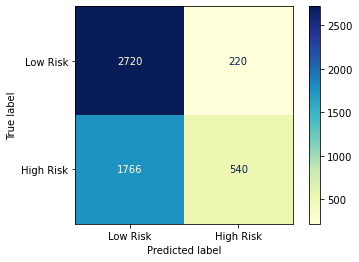

In [83]:
grid_results(logreg_grid2_acc_best)

Hyperparameter Updates:
- class_weight was selected as None this time so I still kept both.
- C selected the largest value so I gave it more options around that.
- solver was liblinear but I still kept the other options just in case.
- max_iter selected the highest so I gave higher options as well.
- penalty chose l1, implementing more regularizaiton, but I still kept the other options just in case.

#### Logistic Regression with Randomized Search (Accuracy) 3

In [84]:
# # Creating parameters for GridSearch
# params = {'logreg__class_weight':['balanced', None],
#                 'logreg__C': [.1, 0.15, 0.05],
#                 'logreg__solver': ['liblinear','lbfgs', 'sag', 'saga'],
#                 'logreg__max_iter': [150, 200, 700],
#                 'logreg__penalty': ['l1', 'l2', 'elasticnet', None]}

# # RandomizedSearch
# logreg_grid3_acc = GridSearchCV(estimator=logreg_pipe, param_grid=params, cv=5, n_jobs=3)

# # Fitting the GridSearch
# logreg_grid3_acc.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/logreg_grid3_acc_best.pkl', 'wb') as f:
#     pickle.dump(logreg_grid3_acc.best_estimator_, f)

In [85]:
# Load the pickled model
with open('pickled_models/logreg_grid3_acc_best.pkl', 'rb') as f:
    logreg_grid3_acc_best = pickle.load(f)

The scores still stayed the same. 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

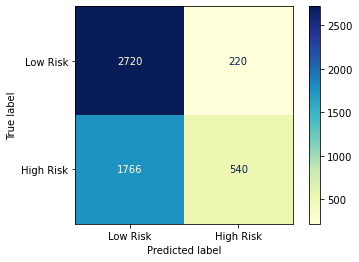

In [86]:
grid_results(logreg_grid3_acc_best)

The Logistic Regression model was aggressively applying regularization in order to improve the recall. While the recall score did rise, the accuracy score was not as good as I was hoping. I decided to try a Gradient Boosting Classifier to see if tweaking of another tree-based model could address the overfitting I saw earlier in the Random Forests.

### Sixth Model: Gradient Boosting Classifier

In [87]:
# # Creating steps for a Pipeline 
# gbc_steps = [('preprocess', preprocessor),
#                 ('gbc', GradientBoostingClassifier(random_state=333))]

# # Feeding the Pipeline the steps defined above
# gbc_pipe = Pipeline(gbc_steps)

# # Fitting the training data to the Pipeline
# gbc_pipe.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_pipe.pkl', 'wb') as f:
#     pickle.dump(gbc_pipe, f)

In [88]:
# Load the pickled model
with open('pickled_models/gbc_pipe.pkl', 'rb') as f:
    gbc_pipe = pickle.load(f)

The initial gradient boosting classifier with default parameters showed a pretty bad recall score with a decent accuracy score. Both however, were very underfit. Again, my first goal was to run a grid search in an attempt to overfit the model.

Train Recall:  0.30875975715524717
CV Recall:  0.2719027899071283

Train Accuracy:  0.6513534121235227
CV Accuracy:  0.610751645558128


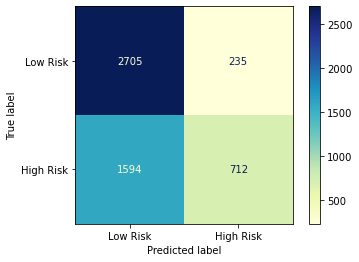

In [89]:
cv_scores(gbc_pipe)

#### Gradient Boosting Classifier with Grid Search 1

In [90]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [0.01, .1, 1],
#           'gbc__n_estimators': [100, 200],
#          'gbc__min_samples_split': [2, 3],
#          'gbc__max_depth': [3, None]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid1 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3, verbose=2)

# # Fitting the GridSearch
# gbc_grid1.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid1_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid1.best_estimator_, f)

In [91]:
# Load the pickled model
with open('pickled_models/gbc_grid1_best.pkl', 'rb') as f:
    gbc_grid1_best = pickle.load(f)

The initial grid search was successful in overfitting the model. It increased the recall score and decreased the accuracy score, but now I was able to tune the model and try to increase both metrics from that starting point.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

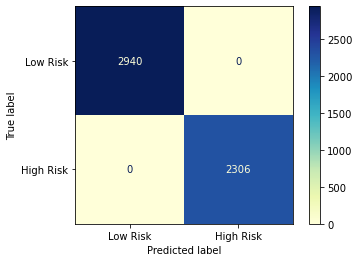

In [92]:
grid_results(gbc_grid1_best)

Hyperparameter Tuning:
- loss was exponenential but kept both just in case.
- learning_rate of .1 but still kept other options. 
- n_estimators selected the largest so I gave another larger option.
- min_samples_split stayed at default 2 but I kept both options.
- max_depth stayed at default None so I increased the lower options.

#### Gradient Boosting Classifier with Grid Search 2

In [93]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [0.01, .1, 1],
#           'gbc__n_estimators': [100, 200, 300],
#          'gbc__min_samples_split': [2, 3],
#          'gbc__max_depth': [10, 30, None]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid2 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid2.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid2_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid2.best_estimator_, f)

In [94]:
# Load the pickled model
with open('pickled_models/gbc_grid2_best.pkl', 'rb') as f:
    gbc_grid2_best = pickle.load(f)

The recall slightly improved with the accuracy dropping a tad but the model is still very overfit, showing there's much more improvement available.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

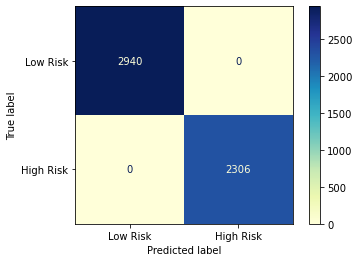

In [95]:
grid_results(gbc_grid2_best)

Hyperparameter Tuning:
- loss was exponenential but still kept both just in case.
- learning_rate of .1 but still kept other options. 
- n_estimators selected the largest so I gave another larger option.
- min_samples_split stayed at default 2 so I increased the other option.
- max_depth selected 30 so I offered more options around that.

#### Gradient Boosting Classifier with Gradient Search 3

In [96]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [0.01, .1, 1],
#           'gbc__n_estimators': [200, 300, 400],
#          'gbc__min_samples_split': [2, 4],
#          'gbc__max_depth': [20, 30, 40]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid3 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid3.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid3_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid3.best_estimator_, f)

In [97]:
# Load the pickled model
with open('pickled_models/gbc_grid3_best.pkl', 'rb') as f:
    gbc_grid3_best = pickle.load(f)

Recall increased by half a percentage and accuracy increased by a tiny amount. The model is still overfit so still more tweaking to be done.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

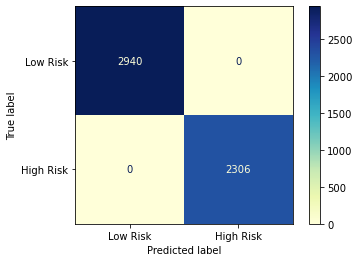

In [98]:
grid_results(gbc_grid3_best)

Hyperparameter Tuning:
- loss was exponenential but still kept both just in case.
- learning_rate increased to 1 so also gave a higher option. 
- n_estimators selected the largest so I gave larger options.
- min_samples_split stayed at default 2 so I increased the other options.
- max_depth selected 20 so I gave the lower option of 10 again.

#### Gradient Boosting Classifier with Gradient Search 4

In [99]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [1.5, .1, 1],
#           'gbc__n_estimators': [600, 500, 400],
#          'gbc__min_samples_split': [2, 4, 6],
#          'gbc__max_depth': [15, 20, 25],
#          'gbc__max_features': [None, 10, 20]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid4 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid4.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid4_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid4.best_estimator_, f)

In [100]:
# Load the pickled model
with open('pickled_models/gbc_grid4_best.pkl', 'rb') as f:
    gbc_grid4_best = pickle.load(f)

The model did not improve at all. This called for more drastic changes to the parameter options. 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

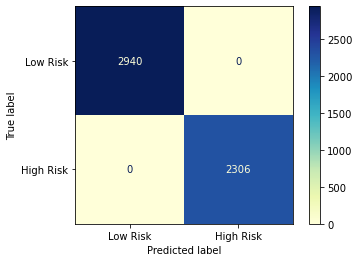

In [101]:
grid_results(gbc_grid4_best)

Hyperparameter Tuning:
- loss was exponenential but kept both because now added subset.
- learning_rate of 1 was selected again so I kept that. 
- n_estimators selected largest again so I continued to increase that option.
- min_samples_split remained at 2 so I played around with 3 again.
- max_depth remained at 20 I decided to give a closer lower option as well.
- max_features stayed at None so I now gave a higher option getting closer to the total 31 features I have. 
- subsample was added as 1 and 0.5. A subsample less than 1 leads to a decrease in variance and an increase in bias (accuracy).


#### Gradient Boosting Classifier with Gradient Search 5

In [102]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [1],
#           'gbc__n_estimators': [600, 700],
#          'gbc__min_samples_split': [2, 3],
#          'gbc__max_depth': [18, 20],
#          'gbc__max_features': [None, 25],
#          'gbc__subsample': [0.5, 1]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid5 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid5.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid5_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid5.best_estimator_, f)

In [103]:
# Load the pickled model
with open('pickled_models/gbc_grid5_best.pkl', 'rb') as f:
    gbc_grid5_best = pickle.load(f)

The recall score increased by .5 and the accuracy decreased by .5 but the model reduced it's overfittedness. 

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

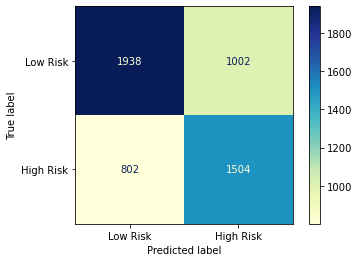

In [104]:
grid_results(gbc_grid5_best)

Hyperparameter Tuning:
- loss was deviance but kept both to be safe.
- n_estimators continued to take 600 so I tried 550 and 650 as well.
- min_samples_split increased to 3 so I also tried 4.
- max_depth remained at 20 I decided to give a closer higher option as well because there's room to be a bit more overfit.
- max_features decreased to 25 so I gave another option closer to 25
- subsample selected 0.5 so I offered another option below 1.

#### Gradient Boosting Classifier with Grid Search 6

In [105]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [1],
#           'gbc__n_estimators': [550, 600, 650],
#          'gbc__min_samples_split': [4, 3],
#          'gbc__max_depth': [20, 22],
#          'gbc__max_features': [22, 25],
#          'gbc__subsample': [0.5, 0.75]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid6 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid6.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid6_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid6.best_estimator_, f)

In [106]:
# Load the pickled model
with open('pickled_models/gbc_grid6_best.pkl', 'rb') as f:
    gbc_grid6_best = pickle.load(f)

Again the recall increased slightly and the accuracy decreased slightly.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

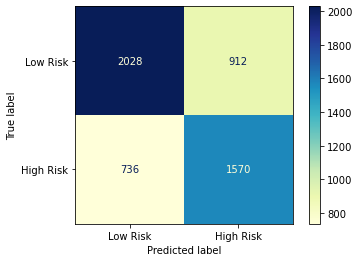

In [107]:
grid_results(gbc_grid6_best)

Hyperparameter Tuning:
- loss was deviance but still kept both to be safe. It appears that the subsets work well with deviance loss.
- n_estimators was 550 so I also offered 500.
- min_samples_split increased to 4 so I also tried 5.
- max_depth was 22 so I also tried 24
- max_features stayed at 25 so I gave another higher option.
- subsample stayed at 0.5 so I also gave 0.6 as a closer option.

#### Gradient Boosting Classifier with Grid Search 7

In [108]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [1],
#           'gbc__n_estimators': [550, 600, 500],
#          'gbc__min_samples_split': [4, 5],
#          'gbc__max_depth': [24, 22],
#          'gbc__max_features': [27, 25],
#          'gbc__subsample': [0.5, 0.6]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid7 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid7.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid7_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid7.best_estimator_, f)

In [109]:
# Load the pickled model
with open('pickled_models/gbc_grid7_best.pkl', 'rb') as f:
    gbc_grid7_best = pickle.load(f)

The accuracy and recall scores increased slightly.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

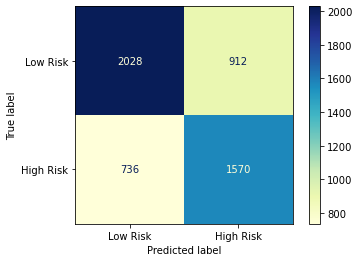

In [110]:
grid_results(gbc_grid7_best)

Hyperparameter Tuning:
- loss was deviance but I still kept both options just to be safe. 
- n_estimators was 500 so I gave below that. 
- min_samples_split was 4 so I kept that the same with an option above.
- max_depth was 22 again so I narrowed the option.
- max_features stayed at 25 so I narrowed the option.
- subsample stayed at 0.5 so I gave it an option below.

#### Gradient Boosting Classifier with Grid Search 8

In [111]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['exponential', 'deviance'],
#           'gbc__learning_rate': [1, .5],
#           'gbc__n_estimators': [450, 500],
#          'gbc__min_samples_split': [4, 5],
#          'gbc__max_depth': [23, 22],
#          'gbc__max_features': [26, 25],
#          'gbc__subsample': [0.4, 0.5]}

# GradientBoostingClassifier()

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid8 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid8.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid8_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid8.best_estimator_, f)

In [112]:
# Load the pickled model
with open('pickled_models/gbc_grid8_best.pkl', 'rb') as f:
    gbc_grid8_best = pickle.load(f)

The recall score increased to over 50% and while the accuracy dropped a little, it also stayed above 50%!

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

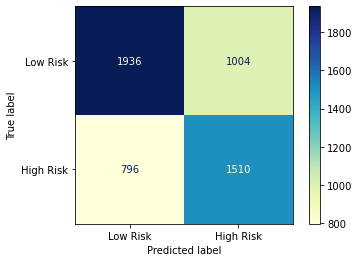

In [113]:
grid_results(gbc_grid8_best)

Hyperparameter Tuning:
- loss was deviance again. It's clear that the subset works best with deviance so I kept just that.
- n_estimators was 450 so I gave another option below that. 
- min_samples_split was 4 so I gave an option above.
- max_depth was 23 so I gave an option above.
- max_features stayed at 25 so I gave an option below.
- subsample dropped to 0.4 so I gave another option below.

#### Gradient Boosting Classifier with Grid Search 9

In [114]:
# # Creating parameters for GridSearch
# params = {'gbc__loss': ['deviance'],
#           'gbc__learning_rate': [1, .5],
#           'gbc__n_estimators': [450, 400],
#          'gbc__min_samples_split': [7, 6, 5],
#          'gbc__max_depth': [23, 24],
#          'gbc__max_features': [24, 25],
#          'gbc__subsample': [0.3, 0.4]}

# # GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
# gbc_grid9 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# # Fitting the GridSearch
# gbc_grid9.fit(X_train, y_train)

# # Pickle the model
# with open('pickled_models/gbc_grid9_best.pkl', 'wb') as f:
#     pickle.dump(gbc_grid9.best_estimator_, f)

In [115]:
# Load the pickled model
with open('pickled_models/gbc_grid9_best.pkl', 'rb') as f:
    gbc_grid9_best = pickle.load(f)

Both the recall and accuracy increased!

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

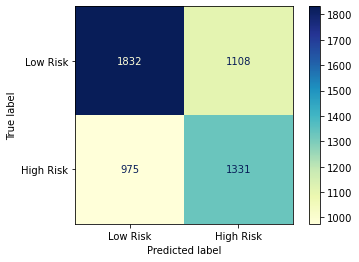

In [116]:
grid_results(gbc_grid9_best)

Hyperparameter Tuning:
- loss I kept at deviance.
- n_estimators was 450 so I gave two closer options. 
- min_samples_split was 7 so I gave two options above.
- max_depth was 23 again but I kept 24 as well just in case.
- max_features stayed at 25 but I kept both just in case.
- subsample dropped to 0.3 so I gave two lower options.

#### Gradient Boosting Classifier with Grid Search 10

In [155]:
# Creating parameters for GridSearch
params = {'gbc__loss': ['deviance'],
          'gbc__learning_rate': [1, .5],
          'gbc__n_estimators': [475, 450, 425],
         'gbc__min_samples_split': [7, 8, 9],
         'gbc__max_depth': [23, 24],
         'gbc__max_features': [24, 25],
         'gbc__subsample': [0.3, 0.2, 0.1]}

# GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
gbc_grid10 = GridSearchCV(estimator=gbc_pipe, param_grid=params, cv=5, scoring=recall_scorer, n_jobs=3)

# Fitting the GridSearch
gbc_grid10.fit(X_train, y_train)

# Pickle the model
with open('pickled_models/gbc_grid10_best.pkl', 'wb') as f:
    pickle.dump(gbc_grid10.best_estimator_, f)

In [118]:
# Load the pickled model
with open('pickled_models/gbc_grid10_best.pkl', 'rb') as f:
    gbc_grid10_best = pickle.load(f)

Recall increased a little bit and accuracy decreased a tad but both are still about 50%.

Recall
Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Semester_Credit_Load',
                                                   'CGPA']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Course', 'Gender',
                                                   'Relationship_Status',
                                                   'Family_History',
                                                   'Residence_Type',
                                                   'Chronic_Illness']),
                                                 ('ord',
                                                  OrdinalEncoder(categorie

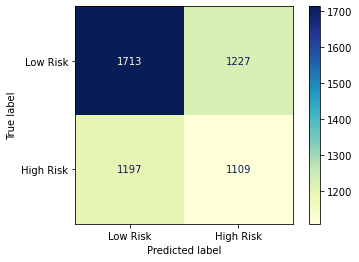

In [119]:
grid_results(gbc_grid10_best)

As the recall score was starting to increase, the accuracy was starting to decrease so I stopped tweaking and used this as my final model.

In [163]:
# Explore feature importances
importances = gbc_grid10.named_steps['gbc'].feature_importances_
importances
features = gbc_grid10.named_steps['preprocess'].get_feature_names_out()

AttributeError: 'GridSearchCV' object has no attribute 'named_steps'

### Final Model

The final model was the Gradient Boosting Classifier with Grid Search 10 with the following hyperparameters:
- loss: deviance
- learning_rate: 0.5
- n_estimators: 475
- min_samples_split: 8
- max_depth: 24
- max_features: 25
- subsample: 0.1

Recall Score:  0.4949874686716792
Accuracy Score:  0.5105774728416238

Best Estimator Confusion Matrix on Training Data with no CV


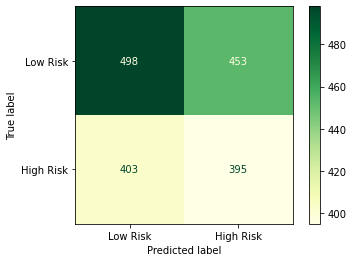

In [120]:
y_pred = gbc_grid9_best.predict(X_test)

print('Recall Score: ', recall_score(y_test, y_pred))
print('Accuracy Score: ', accuracy_score(y_test, y_pred))

print('')
print('Best Estimator Confusion Matrix on Training Data with no CV')
# Creating confusion matrix
cf = confusion_matrix(y_test, y_pred)
# Displaying confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['Low Risk', 'High Risk']).plot(cmap='YlGn');

## Conclusion

When deployed on the testing data, the final model received recall score of 49% and an accuracy score of 51%. This was comparable to the cross validation score and was expected.

The main challenge in this project was attempting to obtain both a high recall and accuracy score. While recall is the most important because we don't want to accidentally ignore a high risk student, many models were simply doing just what the Dummy Model would do. The models struggled with correctly predicting whether a student was high or low risk because none of the columns in the dataset had a strong correlation with depression. This could be due to dishonest responses from students, simplistic snapshots of a student's complex life that doesn't take into consideration their true experiences, or most likely, a combination of both of these.

## Next Steps

After this research, I think the best way forward is to obtain honest data through a Cohort Survey with quantifiable questions that follow poarticipants over the course of a semester or school year. 

The quantifiable questions are important because humans tend to lie when talking about hard topics like depression. And even when they're not consciously lying, everyone has a different lens through which they view life. For example, a good night's sleep to someone may be a poor night's sleep to another. To resolve this, we need the survey to include quantifiable questions such as, how many hours of sleep do you get? 

Following the participants over the course of a semester or school year is important because human emotions vary greatly from day to day, hour to hour, minute to minute. A student stressed out to the max during an exam week may answer these questions differently than when they have very few assignments due. Having students take daily or weekly surveys throughout the year would allow us to average the data and get a more realistic picture of how each individual is truly doing. 